# Procesamiento Adaptativo de Señales - TP4 - Grupo 2

Importar librerias necesarias

In [62]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.fft import fft, fftshift
from scipy.io import wavfile

Importar archivo de audio

In [63]:
Fs = 16e3
Fc = 2e3
v_sound = 343 # [m/s]

# Distancia entre sensores
d = [0.04, 0.08, 0.16]

subarray_sensors = [[3, 4, 5, 6, 7, 8,  9, 10, 11],
                    [1, 2, 3, 5, 7, 9, 11, 12, 13],
                    [0, 1, 3, 7, 11, 13, 14]]

M = [len(s) for s in subarray_sensors]

rate, data = wavfile.read('mtms-arrC1A.wav')
length = data.shape[0] / rate
N = len(data)
data = np.swapaxes(data,0,1) # Fila son canales, columnas son tiempo

## Punto 1

In [88]:
def butter_lowpass_sos(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    sos = signal.butter(order, normal_cutoff, btype='low', analog=False, output='sos')
    return sos

C:\Users\Matias\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\cbook\__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


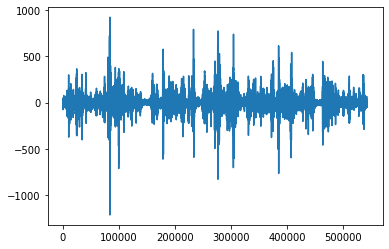

In [121]:
a = 1
b = signal.firwin(101, 100, window='hamming', fs=Fs)

exp_demod = np.exp(2j*np.pi*Fc/Fs* np.arange(len(data[0])))
x = exp_demod * data[0]
test = signal.lfilter(b, a, x)

plt.plot(test)

In [124]:
def v(phi, M, d):
    l = 343/Fc
    return M**-0.5 * np.exp(-2j * np.pi * d * np.sin(phi) / l * np.arange(0, M))

array_idx = 0
B = 100 

a = 1
b = signal.firwin(101, B, window='hamming', fs=Fs)

data_demod = np.zeros(np.shape(data), dtype=np.complex_)
data_filt = np.zeros(np.shape(data), dtype=np.complex_)
exp_demod = np.exp(2j*np.pi*Fc/Fs* np.arange(len(data[0])))
for i, val in enumerate(data):
    data_demod[i] = exp_demod * val
    data_filt[i] = signal.lfilter(b, a, data_demod[i])

C:\Users\Matias\AppData\Local\Temp/ipykernel_7228/1587917186.py:2: RuntimeWarning: divide by zero encountered in log10
  img_data = 10*np.log10( np.abs(data_filt[ subarray_sensors[array_idx] ] ))


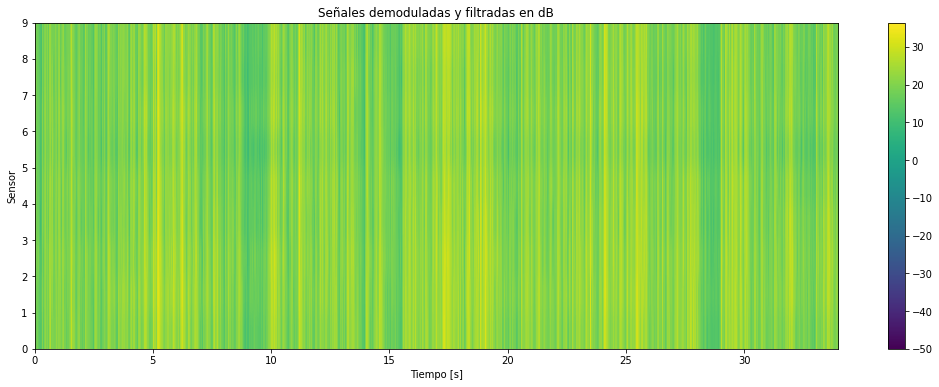

In [130]:
plt.figure(figsize=(18, 6))
img_data = 10*np.log10( np.abs(data_filt[ subarray_sensors[array_idx] ] ))
img = plt.imshow( img_data, interpolation='antialiased', aspect='auto', extent=[0, len(data[0])/Fs, 0, M[array_idx]], vmin = -50, origin='lower')
plt.colorbar(img, ax=plt.gca())
plt.title('Señales demoduladas y filtradas en dB')
plt.ylabel('Sensor')
plt.xlabel('Tiempo [s]')
plt.show()

C:\Users\Matias\AppData\Local\Temp/ipykernel_7228/2081200885.py:8: RuntimeWarning: divide by zero encountered in log10
  img_data = 10*np.log10( np.abs(data_fft))


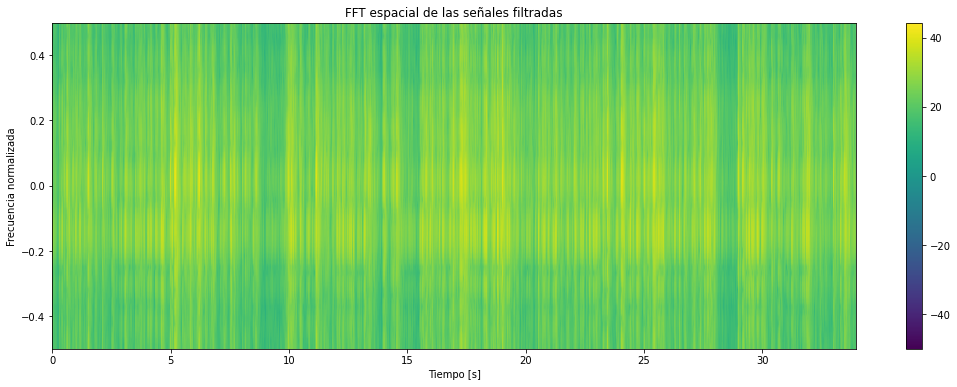

In [129]:
padding = 64 - len(data_filt)
data_fft = np.zeros((M[array_idx] + padding, N), dtype=np.complex_)
for t in range(len(data_filt[0])):
    data_pad = np.pad( data_filt[ subarray_sensors[array_idx] , t], (0, padding) )
    data_fft[:, t] = fftshift( fft( data_pad ) )

plt.figure(figsize=(18, 6))
img_data = 10*np.log10( np.abs(data_fft))
img = plt.imshow( img_data, interpolation='antialiased', aspect='auto', extent=[0, len(data[0])/Fs, -0.5, 0.5], vmin = -50, origin='lower')
plt.colorbar(img, ax=plt.gca())
plt.title('FFT espacial de las señales filtradas')
plt.ylabel('Frecuencia normalizada')
plt.xlabel('Tiempo [s]')
plt.show()

C:\Users\Matias\AppData\Local\Temp/ipykernel_7228/1243099710.py:7: RuntimeWarning: divide by zero encountered in log10
  img_data = 10*np.log10( np.abs(data_fft))


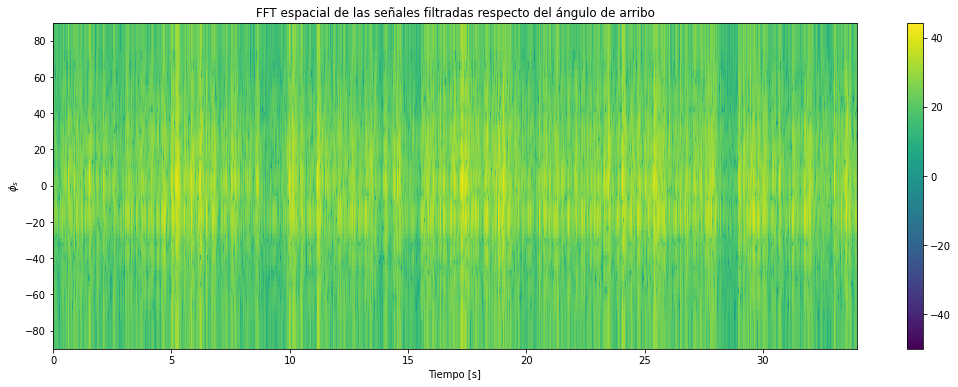

In [132]:
x = np.linspace(0, len(data_fft[0])/Fs, len(data_fft[0])+1)
y = np.linspace(-0.5, 0.5, len(data_fft)+1)
y = np.arcsin(y*2) * 180/np.pi
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))
img_data = 10*np.log10( np.abs(data_fft))
img = plt.pcolormesh(X, Y, img_data, antialiased=True, vmin = -50)
plt.colorbar(img, ax=plt.gca())
plt.title('FFT espacial de las señales filtradas respecto del ángulo de arribo')
plt.ylabel('$\phi_s$')
plt.xlabel('Tiempo [s]')
plt.show()

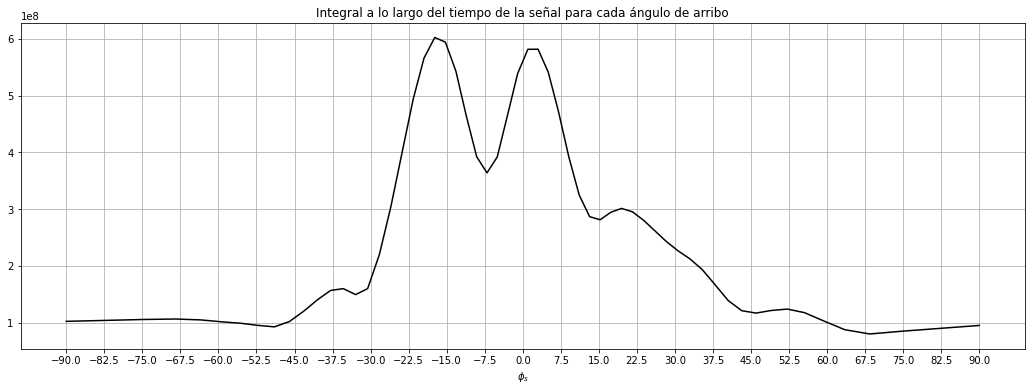

In [157]:
plt.figure(figsize=(18, 6))
plt.plot( np.arcsin(np.linspace(-1, 1, len(data_fft))) * 180/np.pi , np.abs(data_fft).sum(axis=1), 'k')
plt.title('Integral a lo largo del tiempo de la señal para cada ángulo de arribo')
plt.xticks(np.linspace(-90, 90, 24+1))
plt.xlabel('$\phi_s$')
plt.grid()
plt.show()

# Responder preguntas teoricas ...........

## Punto 2